[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/HSinger04/ANNwTFHW5/ANNwTFHW5.ipynb)

## Disclaimer

The architecture used in this notebook consists largely of code from https://arxiv.org/pdf/1608.06037.pdf. Differences among other things are the usage of ELU instead of ReLu like in the original paper.
Possibly, there are also other parts we have implemented differently from the original authors in their paper.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, \
    BatchNormalization, ELU, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.regularizers import L2
from tensorflow.image import random_brightness, random_hue, random_saturation
from functools import partial  

## Define Model

In [2]:
class ConvNet(Model):

    def __init__(self):
        super(ConvNet, self).__init__()
        # store architecture as a list to avoid naming individual layers
        architecture = []

        def conv_sub_arch(filters, kernel_size=[3,3]):
            """ Convenience function for returning getting used sub architectures """
            architecture.extend([ZeroPadding2D(), \
                                 Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=L2()), \
                                 BatchNormalization(), ELU()])

        def pool_sub_arch():
            """ Another convenience function for getting often used sub architectures """
            architecture.extend([MaxPooling2D(), Dropout(0.1)])
        
        conv_sub_arch(64)
        for i in range(3):
            conv_sub_arch(128)
        pool_sub_arch()   
        for i in range(3):
            conv_sub_arch(128)
        pool_sub_arch()   
        conv_sub_arch(256)
        conv_sub_arch(256)
        pool_sub_arch()
        conv_sub_arch(512)
        conv_sub_arch(1024)
        pool_sub_arch()
        conv_sub_arch(128)
        conv_sub_arch(128, kernel_size=[1,1])
        conv_sub_arch(128, kernel_size=[1,1])
        pool_sub_arch()
        conv_sub_arch(128)
        pool_sub_arch()
        architecture.append(Flatten())
        architecture.append(Dense(10, activation=tf.keras.activations.softmax))

        self.architecture = architecture

     
    # no tf.function as that prevents us from switching between training
    # and evaluation mode in call method
    def call(self, x, training):
        for layer in self.architecture:
            if isinstance(layer, Dropout) or isinstance(layer, BatchNormalization):
                x = layer(x, training=training)
            else:
                x = layer(x)                   
        return x        

## Load dataset

In [3]:
train_data, test_data = tfds.load(
    'cifar10', split=['train', 'test'], as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete451ZR4/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete451ZR4/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Inspect data set

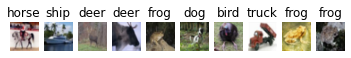

In [4]:
fig, ax = plt.subplots(1,10)
shapes = []

num_to_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
"ship", "truck"]

for i, (img, lbl) in enumerate(train_data):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(num_to_name[lbl.numpy()])
    ax[i].axis("off")
    shapes.append(img.shape)

## Define some constants

In [5]:
# arbitrarily set. Feel free to change these
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

## Prepare data

In [6]:
def process_inp_and_label(input, label, training):
    """ rescale inputs and onehotify labels """
    new_input = input / 255
    return new_input, tf.one_hot(label, 10)

def data_pipeline(data, training):
    """ helper function for data pipeline - does all the things we need """
    map_func = partial(process_inp_and_label, training=training)
    data = data.map(map_func)
    # arbitrarily set buffer_size - feel free to use sth. else
    data = data.shuffle(buffer_size=BATCH_SIZE)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

train_data = data_pipeline(train_data, True)
test_data = data_pipeline(test_data, False)

## Define helper functions

In [7]:
def train_step(model, input, target, loss_function, optimizer):
    accuracy = None

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:    
        # boolean argument for training mode
        prediction = model(input, True)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = np.mean(accuracy)

    return loss, accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        # boolean argument for evaluation mode
        prediction = model(input, False)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.extend(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

## Prepare for training

In [8]:
tf.keras.backend.clear_session()

In [9]:
num_epochs = 10
learning_rate = 0.001
# set to 0 if you want to use mean instead of running average
running_average_factor = 0
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

model = ConvNet()

# define calc_stat here to access running_average_factor
def calc_stat(stat_so_far, new_stat, stat_num):
    """Calculates appropriate statistic

    :param stat_so_far: the statistic that we have observed so far
    :param new_stat: the newest observed statistic
    :param stat_num: new_stat is the stat_num-th observed statistic
    :return: if 0, return mean, else running average
    """

    if running_average_factor:
        return running_average_factor * stat_so_far + (1 - running_average_factor) * new_stat
    # calculate mean of observed statistics so far
    return ((stat_num - 1) * stat_so_far + new_stat) / stat_num

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

##Train

In [10]:
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch+1))

    # shuffle train data. No need to shuffle test data
    train_data = train_data.shuffle(buffer_size=BATCH_SIZE)

    train_loss_stat = 0
    train_accuracy_stat = 0
    for i, (input, target) in enumerate(train_data):
        train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
        train_loss_stat = calc_stat(train_loss_stat, train_loss, i+1)
        train_accuracy_stat = calc_stat(train_accuracy_stat, train_accuracy, i+1)
    train_losses.append(train_loss_stat)
    train_accuracies.append(train_accuracy_stat)

    # testing
    test_loss, test_accuracy = test(model, test_data, loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


##Plot

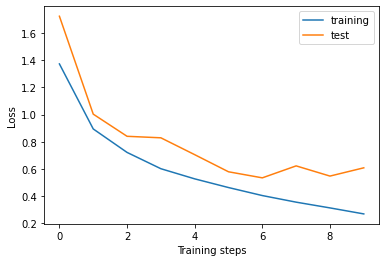

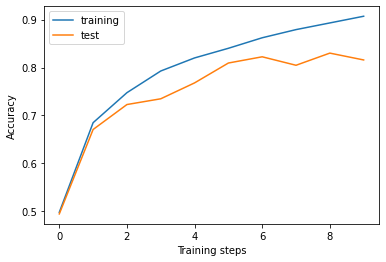

In [11]:
plot_stats(train_losses, test_losses, "Loss")
plot_stats(train_accuracies, test_accuracies, "Accuracy")

## Assert test accuracy over 85%

In [12]:
assert test_accuracies[-1] >= 0.85
print(test_accuracies)

AssertionError: ignored